In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import cf_xarray as cfxr

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats
from datetime import timedelta

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import string
alphabet = list(string.ascii_lowercase)       

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Import data

## Green's Function

In [3]:
G_ds_path = 'Outputs/G_pulse_ds.nc4'
G_cdr_ds_path = 'Outputs/G_cdr_ds.nc4'

G_ds = utils.import_polyfit_G(G_ds_path, G_cdr_ds_path)

## Convolution

In [4]:
conv_mean_ds = xr.open_dataset('Outputs/conv_mean_ds.nc4')['__xarray_dataarray_variable__']

conv_ds = xr.open_dataset('Outputs/conv_ds.nc4')['__xarray_dataarray_variable__']

conv_hist_mod_mean_ds = xr.open_dataset('Outputs/hist_co2_only_conv_ds.nc4')['__xarray_dataarray_variable__']


## CMIP6 1pct

In [5]:
ds_dif = xr.open_dataset('Outputs/ds_dif.nc4')

ds_hist_dif = xr.open_dataset('Outputs/hist_co2_only_ds_dif.nc4')

## Emissions profile

In [6]:
emis_profile = xr.open_dataset('Outputs/emis_profile.nc4')


## PiCtrl

In [7]:
ds_pictrl = xr.open_dataset('Outputs/ds_pictrl.nc4')

## Model Dicts

In [8]:
model_run_pulse_dict = utils.model_run_pulse_dict
model_run_1pct_dict = utils.model_run_1pct_dict
model_run_control_dict = utils.model_run_esm_picontrol_dict
model_run_1pct1000gtc_dict = utils.model_run_1pct_1000gtc_dict


# Settings and Define our Model Weights

In [9]:
#define our weights for models (grouping UKESM and CANESM realizations)
model_weights = utils.model_weights

onepct_model_weights = utils.onepct_model_weights

G_model_weights = utils.G_model_weights

pictrl_model_weights = utils.pictrl_model_weights

In [10]:
type_color = utils.type_color
model_color = utils.model_color

In [11]:
A = utils.A
ds_out = utils.ds_out

In [12]:
proper_names = utils.proper_names

## Emissions profile

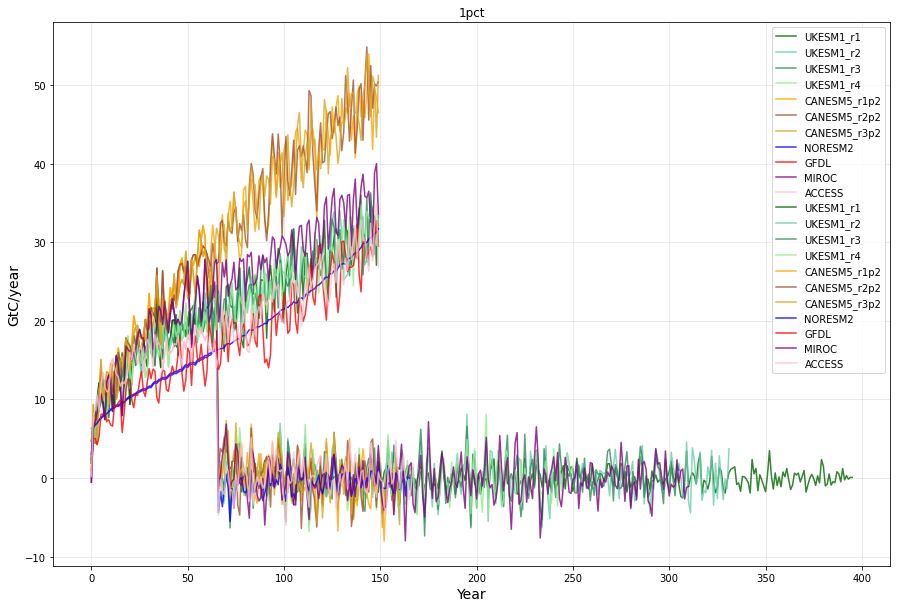

In [15]:
fig, ax = plt.subplots(figsize = [15,10])
for exp in ['1000gtc','1pct']:
    for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2', 'NORESM2', 'GFDL', 'MIROC', 'ACCESS']:
        plt.plot(emis_profile.sel(model = m, experiment = exp)['emis'], alpha = .8, label = f'{m}', color = model_color[m])
    #plt.plot(emis_profile.mean(dim = 'model')['emis'], color = 'k', label = f'Model Mean')
    plt.legend()
    plt.xlabel('Year', fontsize = 14)
    plt.ylabel('GtC/year', fontsize = 14)
    plt.title(exp)
    plt.grid(alpha = .3)
plt.savefig('figures/1pct_increase/emis.png', dpi = 350, bbox_inches = 'tight')


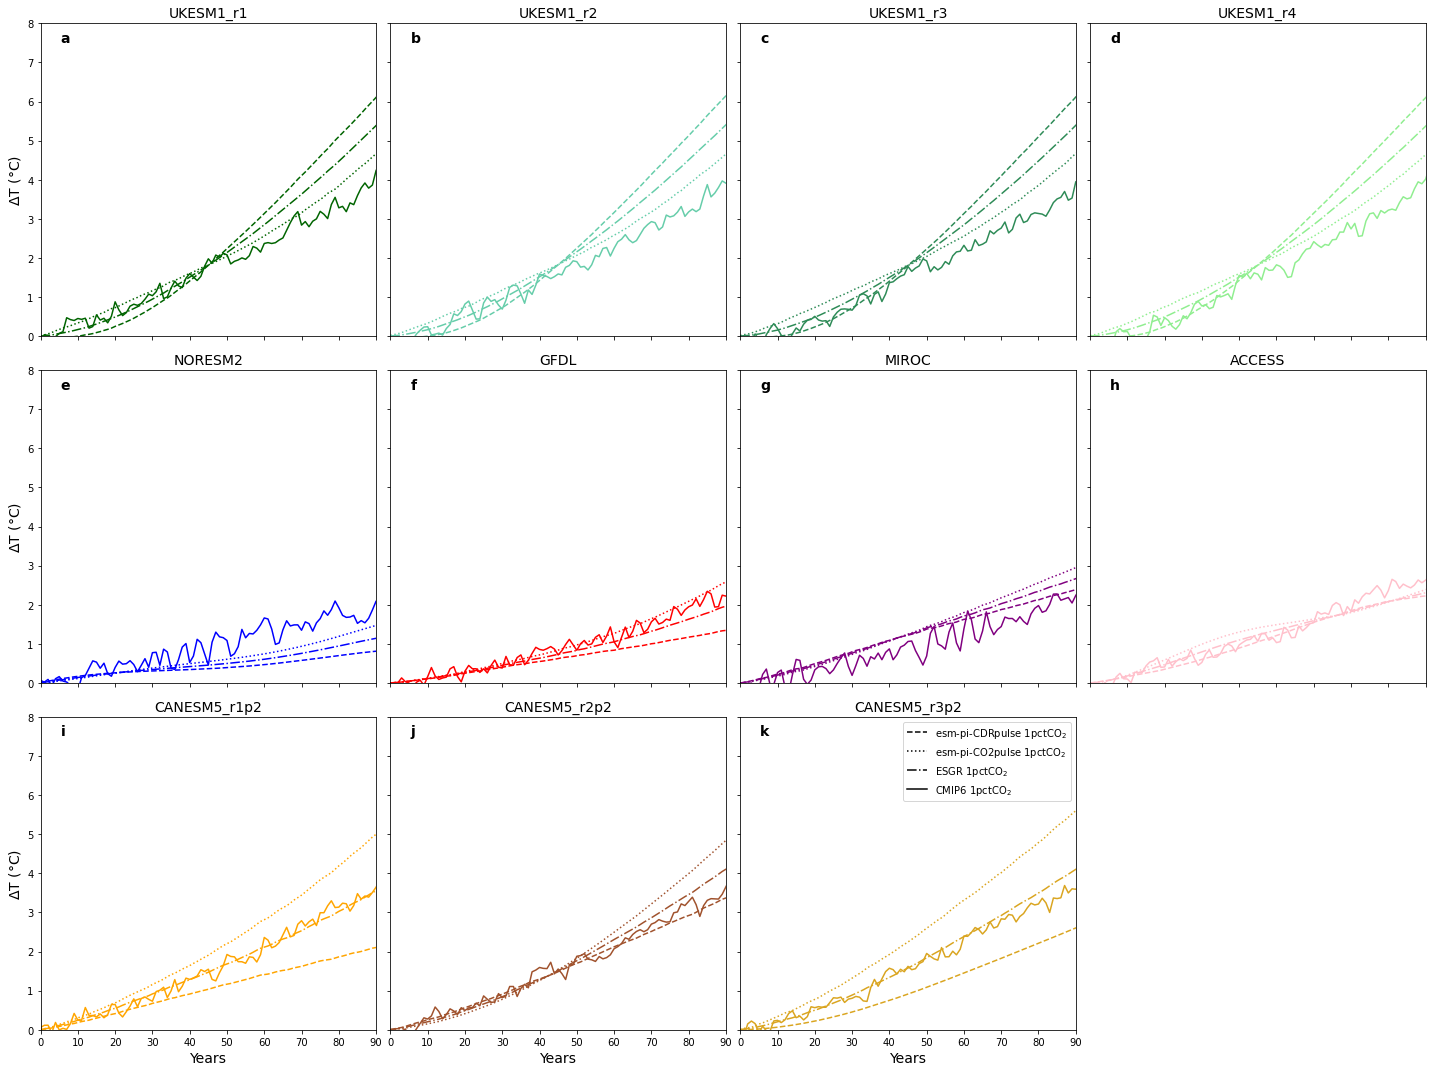

In [13]:
fig, axes = plt.subplots(3, 4,figsize = [20,15], sharey = True, sharex = True)
exp = '1pct'
alpha_labels = iter(alphabet)
for ax, m in zip(axes.ravel(), ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2', 'GFDL', 'MIROC', 'ACCESS', 'CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2']):
    ax.plot(conv_mean_ds.sel(model = m, pulse_type = 'cdr', experiment = exp), color = model_color[m], linestyle = '--')
    ax.plot(conv_mean_ds.sel(model = m, pulse_type = 'pulse', experiment = exp),color = model_color[m], linestyle = ':')
    ax.plot(conv_mean_ds.sel(model = m).mean(dim = 'pulse_type').sel(experiment = exp), color = model_color[m], linestyle = '-.')
    ax.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon']).sel(model = m, experiment = exp)['tas'], color = model_color[m])

    plt.grid(alpha = 0.4)
    plt.xlim(0,140)
    plt.ylim(0,8)
    ax.set_title(m, fontsize = 14)
    
    
    label = next(alpha_labels)
    ax.text(x = .06, y =.94, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
    ax.set_xlim(0,90)
for idx in np.arange(0,4):
    axes[2,idx].set_xlabel('Years', fontsize = 14)
for idx in np.arange(0,3):
    axes[idx,0].set_ylabel('$\Delta$T ($\degree$C)', fontsize = 14)
fig.delaxes(axes[2,3])
plt.tight_layout()

cdr = Line2D([0], [0], linestyle = '--', label='esm-pi-CDRpulse 1pctCO$_2$', color='black')
co2 = Line2D([0], [0], linestyle = ':', label='esm-pi-CO2pulse 1pctCO$_2$', color='black')
esgr = Line2D([0], [0], linestyle = '-.', label='ESGR 1pctCO$_2$', color='black')
model = Line2D([0], [0], label='CMIP6 1pctCO$_2$', color='black')

handles = [cdr, co2, esgr, model]
plt.legend(handles=handles)

#plt.savefig('figures/paper/supp_1pct_vs_pulses_by_model_mean.png', dpi = 300, bbox_inches = 'tight')

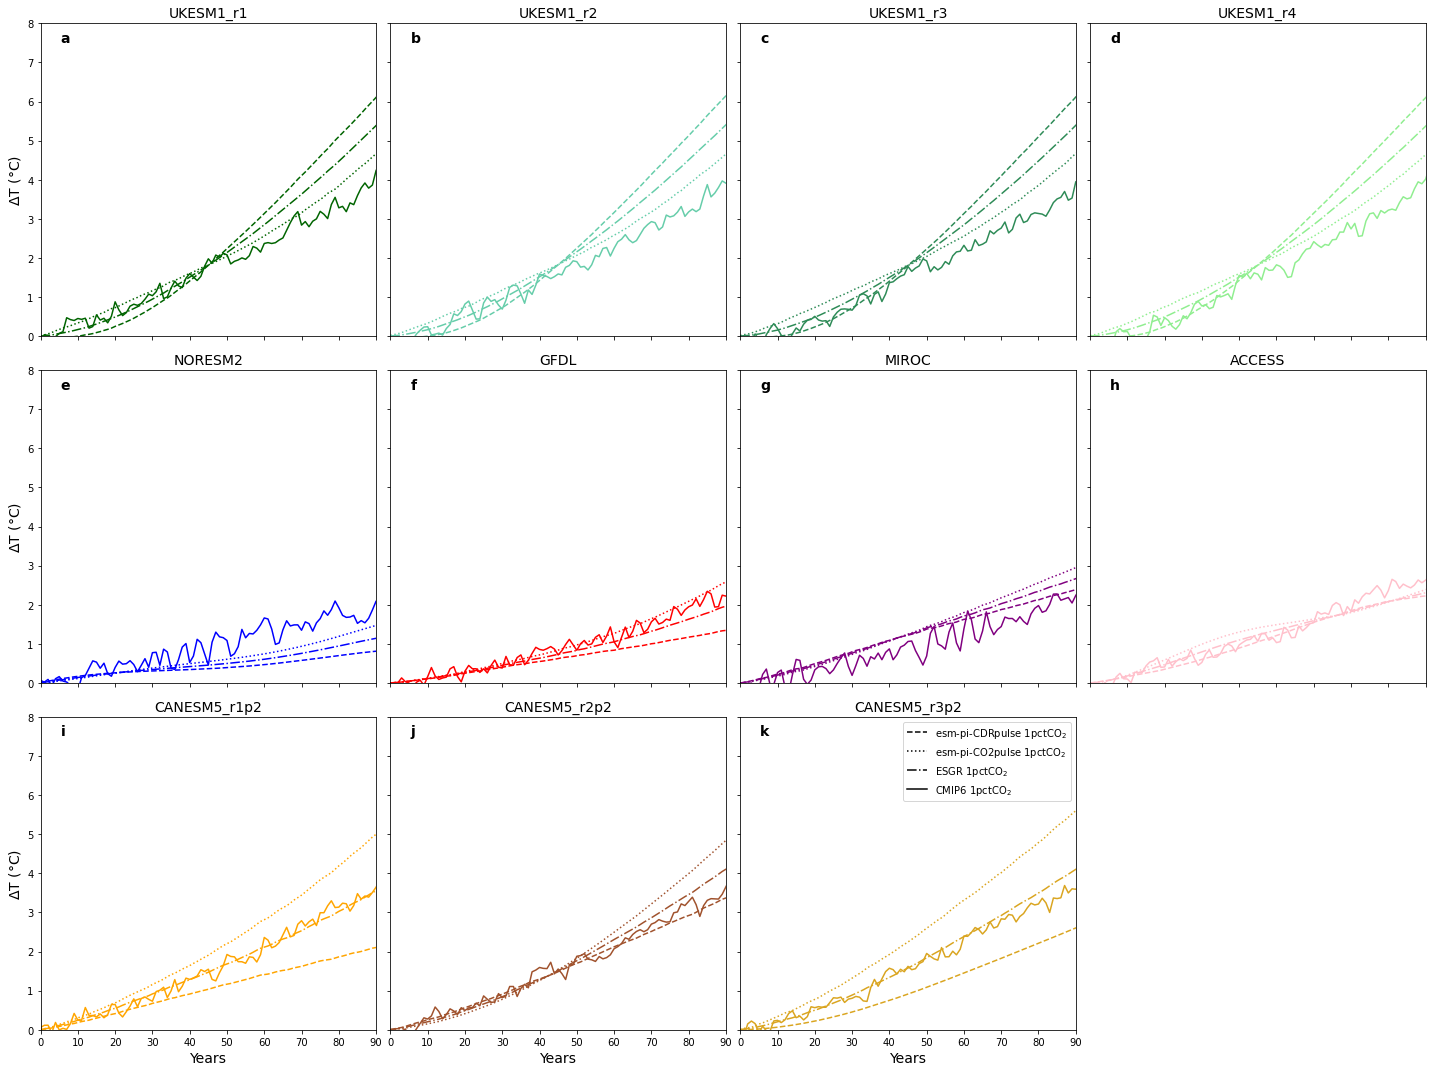

In [13]:
fig, axes = plt.subplots(3, 4,figsize = [20,15], sharey = True, sharex = True)
exp = '1pct'
alpha_labels = iter(alphabet)
for ax, m in zip(axes.ravel(), ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2', 'GFDL', 'MIROC', 'ACCESS', 'CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2']):
    ax.plot(conv_mean_ds.sel(model = m, pulse_type = 'cdr', experiment = exp), color = model_color[m], linestyle = '--')
    ax.plot(conv_mean_ds.sel(model = m, pulse_type = 'pulse', experiment = exp),color = model_color[m], linestyle = ':')
    ax.plot(conv_mean_ds.sel(model = m).mean(dim = 'pulse_type').sel(experiment = exp), color = model_color[m], linestyle = '-.')
    ax.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon']).sel(model = m, experiment = exp)['tas'], color = model_color[m])

    plt.grid(alpha = 0.4)
    plt.xlim(0,140)
    plt.ylim(0,8)
    ax.set_title(m, fontsize = 14)
    
    
    label = next(alpha_labels)
    ax.text(x = .06, y =.94, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
    ax.set_xlim(0,90)
for idx in np.arange(0,4):
    axes[2,idx].set_xlabel('Years', fontsize = 14)
for idx in np.arange(0,3):
    axes[idx,0].set_ylabel('$\Delta$T ($\degree$C)', fontsize = 14)
fig.delaxes(axes[2,3])
plt.tight_layout()

cdr = Line2D([0], [0], linestyle = '--', label='esm-pi-CDRpulse 1pctCO$_2$', color='black')
co2 = Line2D([0], [0], linestyle = ':', label='esm-pi-CO2pulse 1pctCO$_2$', color='black')
esgr = Line2D([0], [0], linestyle = '-.', label='ESGR 1pctCO$_2$', color='black')
model = Line2D([0], [0], label='CMIP6 1pctCO$_2$', color='black')

handles = [cdr, co2, esgr, model]
plt.legend(handles=handles)

plt.savefig('figures/paper/supp_1pct_vs_pulses_by_model_mean.png', dpi = 300, bbox_inches = 'tight')

## TCRE

In [16]:

def reindex_df(df, weight_col):
    """expand the dataframe to prepare for resampling
    result is 1 row per count per sample"""
    df = df.reindex(df.index.repeat(df[weight_col]))
    df.reset_index(drop=True, inplace=True)
    return(df)


data = {'mean': conv_mean_ds.sel(experiment = '1000gtc').mean(dim = ['pulse_type']).sel(s = slice(60,80)).mean(dim = ['s']).values,
        'model': conv_mean_ds.model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]}
df_1000gtc_emulator = pd.DataFrame(data)
df_1000gtc_emulator = reindex_df(df_1000gtc_emulator, weight_col = 'count')

data = {'mean': conv_mean_ds.sel(experiment = '1pct').mean(dim = ['pulse_type']).sel(s = slice(60,80)).mean(dim = ['s']).values,
        'model': conv_mean_ds.model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]}
df_1pct_emulator = pd.DataFrame(data)
df_1pct_emulator = reindex_df(df_1pct_emulator, weight_col = 'count')


data = {'mean': ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).sel(experiment = '1pct').sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].values,
        'model': ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).sel(experiment = '1pct').model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]}

df_1pct_model = pd.DataFrame(data)
df_1pct_model = reindex_df(df_1pct_model, weight_col = 'count')


#######ZEC############

data = {'mean': (conv_mean_ds.sel(experiment = '1000gtc').where(conv_mean_ds['model'].isin(list(model_run_1pct1000gtc_dict.keys())), drop = True).mean(dim = 'pulse_type').sel(
                                                                s = slice(80-10, 80+10)).mean(dim = 's').weighted(A).mean(dim = ['lat','lon']) - 
                    conv_mean_ds.sel(experiment = '1000gtc').where(conv_mean_ds['model'].isin(list(model_run_1pct1000gtc_dict.keys())), drop = True).mean(dim = 'pulse_type').sel(s = 65).weighted(A).mean(dim = ['lat','lon'])).values,
        'model': conv_mean_ds.where(conv_mean_ds['model'].isin(list(model_run_1pct1000gtc_dict.keys())), drop = True).model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 4, 4, 4]}

df_zec_emulator_model = pd.DataFrame(data)
df_zec_emulator_model = reindex_df(df_zec_emulator_model, weight_col = 'count')




data = {'mean': (ds_dif.where(ds_dif['model'].isin(list(model_run_1pct1000gtc_dict.keys())), drop = True).sel(experiment = '1000gtc').sel(
                                                                s = slice(80-10, 80+10)).mean(dim = 's').weighted(A).mean(dim = ['lat','lon']) - 
                    ds_dif.where(ds_dif['model'].isin(list(model_run_1pct1000gtc_dict.keys())), drop = True).sel(experiment = '1000gtc').sel(s = 65).weighted(A).mean(dim = ['lat','lon']))['tas'].values,
        
        'model': ds_dif.where(ds_dif['model'].isin(list(model_run_1pct1000gtc_dict.keys())), drop = True).sel(experiment = '1000gtc').model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 4, 4, 4]}

df_zec_cmip_model = pd.DataFrame(data)
df_zec_cmip_model = reindex_df(df_zec_cmip_model, weight_col = 'count')

## Figure 1

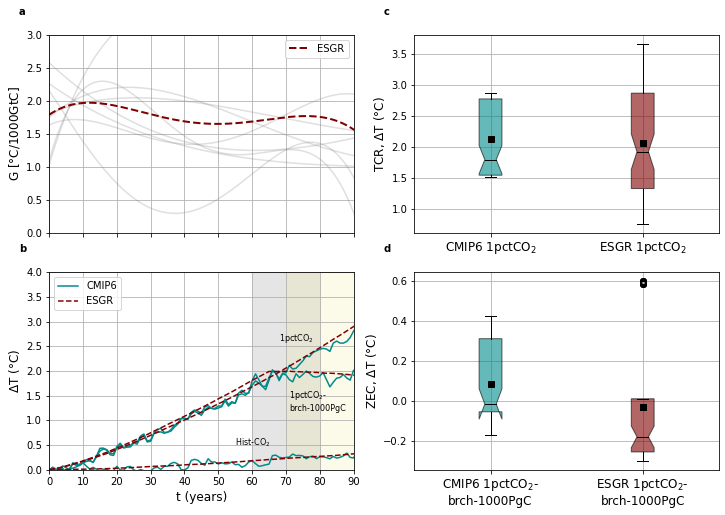

In [15]:
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize = [12,8])
GtC_per_TtC = 1e3
####Plot the GF
for m in G_ds.model:
    (G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).mean(dim = 'pulse_type')*GtC_per_TtC).plot(ax = ax1, color = 'grey', alpha = .25)
ax1.set_title('Annual Mean', fontsize = 16)
ax1.set_xlim(G_ds.s.min(), G_ds.s[90].values)
ax1.set_ylim(0, 3)
(G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model', 'pulse_type'])*GtC_per_TtC).plot(ax = ax1, label = 'ESGR', color = type_color['emulator_1pct'], linewidth = 2, linestyle = '--')
ax1.set_ylabel('G [$\degree$C/1000GtC]', fontsize = 12)
ax1.grid()
ax1.set_xlabel('')
ax1.legend()
ax1.set_xticklabels('')


###Plot the 1pct model runs
ax2.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(model_weights).mean(dim = 'model').weighted(A).mean(dim = ['lat','lon']).sel(experiment = '1pct')['tas'], 
         label = 'CMIP6', color = type_color['model_1pct'])
ax2.plot(np.arange(0,len(ds_dif['s'])), ds_dif.where(ds_dif.model.isin(list(model_run_1pct1000gtc_dict.keys()))).weighted(model_weights).mean(dim = 'model').weighted(A).mean(dim = ['lat','lon']).sel(experiment = '1000gtc')['tas'], 
         color = type_color['model_1000gtc'])

ax2.plot(np.arange(0,len(ds_hist_dif.weighted(A).mean(dim = ['lat','lon'])['s'])), ds_hist_dif.mean(dim = 'model').weighted(A).mean(dim = ['lat','lon'])['tas'], 
         color = type_color['model_1000gtc'])


ax2.plot(conv_mean_ds.weighted(model_weights).mean(dim = ['model', 'pulse_type']).sel(experiment = '1pct'), label = f'ESGR', color = type_color['emulator_1pct'], linestyle = '--')
ax2.plot(conv_mean_ds.weighted(model_weights).mean(dim = ['model', 'pulse_type']).sel(experiment = '1000gtc'), color = type_color['emulator_1000gtc'], linestyle = '--')
ax2.plot(conv_hist_mod_mean_ds.mean(dim = ['model', 'pulse_type']).weighted(A).mean(dim = ['lat','lon']), color = type_color['emulator_1000gtc'], linestyle = '--')


ax2.text(71, 1.2, '1pctCO$_2$-\nbrch-1000PgC', fontsize = 8)
ax2.text(68, 2.6, '1pctCO$_2$', fontsize = 8)
ax2.text(55, 0.5, 'Hist-CO$_2$', fontsize = 8)

ax2.grid()

ax2.axvspan(60, 80, alpha=0.2, color='grey')
ax2.axvspan(70, 90, alpha=0.2, color='khaki')
ax2.legend()
ax2.set_xlim(0,90)
ax2.set_ylim(0, 4)
ax2.set_xlabel('t (years)', fontsize = 12)
ax2.set_ylabel('$\Delta$T ($\degree$C)', fontsize = 12)


####Plot the TCRE comparison
x = ['CMIP6 1pctCO$_2$', 'ESGR 1pctCO$_2$']#, '10 Year Rolling\nMean Emulator']
y = [df_1pct_model['mean'],
    df_1pct_emulator['mean']]#,
colors = [type_color['model_1pct'], type_color['emulator_1pct']]
box = ax3.boxplot(y, showmeans= True, notch = True, patch_artist=True, meanprops={"marker":"s","markerfacecolor":"black", "markeredgecolor":"black"})
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
for median in box['medians']:
    median.set_color('black')
ax3.grid()
ax3.set_ylabel('TCR, $\Delta$T ($\degree$C)', fontsize = 12)
ax3.set_xticklabels(x, fontsize = 12)


####Plot the ZEC comparison
x = ['CMIP6 1pctCO$_2$-\nbrch-1000PgC', 'ESGR 1pctCO$_2$-\nbrch-1000PgC']#, '10 Year Rolling\nMean Emulator']
y = [df_zec_cmip_model['mean'].dropna(),
    df_zec_emulator_model['mean'].dropna()]
    
colors = [type_color['model_1pct'], type_color['emulator_1pct']]
box = ax4.boxplot(y, showmeans= True, notch = True, patch_artist=True, meanprops={"marker":"s","markerfacecolor":"black", "markeredgecolor":"black"})
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
for median in box['medians']:
    median.set_color('black')
ax4.grid()
ax4.set_ylabel('ZEC, $\Delta$T ($\degree$C)', fontsize = 12)
ax4.set_xticklabels(x, fontsize = 12)

alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4]:
    label = next(alpha_labels)
    ax.text(x = -0.1, y =1.1, s = label, transform=ax.transAxes, fontweight="bold")
  
    
plt.savefig('figures/paper/figure1_GF_1pct_TCR.png', bbox_inches = 'tight', dpi = 300)

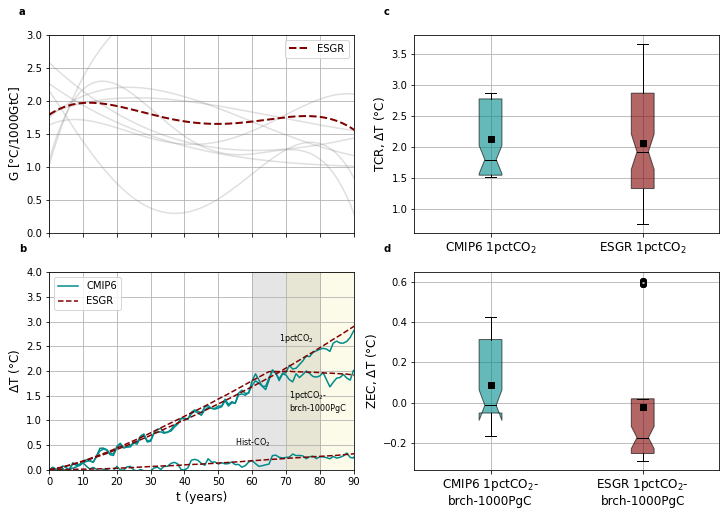

In [16]:
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize = [12,8])
GtC_per_TtC = 1e3
####Plot the GF
for m in G_ds.model:
    (G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).mean(dim = 'pulse_type')*GtC_per_TtC).plot(ax = ax1, color = 'grey', alpha = .25)
ax1.set_title('Annual Mean', fontsize = 16)
ax1.set_xlim(G_ds.s.min(), G_ds.s[90].values)
ax1.set_ylim(0, 3)
(G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model', 'pulse_type'])*GtC_per_TtC).plot(ax = ax1, label = 'ESGR', color = type_color['emulator_1pct'], linewidth = 2, linestyle = '--')
ax1.set_ylabel('G [$\degree$C/1000GtC]', fontsize = 12)
ax1.grid()
ax1.set_xlabel('')
ax1.legend()
ax1.set_xticklabels('')


###Plot the 1pct model runs
ax2.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(model_weights).mean(dim = 'model').weighted(A).mean(dim = ['lat','lon']).sel(experiment = '1pct')['tas'], 
         label = 'CMIP6', color = type_color['model_1pct'])
ax2.plot(np.arange(0,len(ds_dif['s'])), ds_dif.where(ds_dif.model.isin(list(model_run_1pct1000gtc_dict.keys()))).weighted(model_weights).mean(dim = 'model').weighted(A).mean(dim = ['lat','lon']).sel(experiment = '1000gtc')['tas'], 
         color = type_color['model_1000gtc'])

ax2.plot(np.arange(0,len(ds_hist_dif.weighted(A).mean(dim = ['lat','lon'])['s'])), ds_hist_dif.mean(dim = 'model').weighted(A).mean(dim = ['lat','lon'])['tas'], 
         color = type_color['model_1000gtc'])


ax2.plot(conv_mean_ds.weighted(model_weights).mean(dim = ['model', 'pulse_type']).sel(experiment = '1pct'), label = f'ESGR', color = type_color['emulator_1pct'], linestyle = '--')
ax2.plot(conv_mean_ds.weighted(model_weights).mean(dim = ['model', 'pulse_type']).sel(experiment = '1000gtc'), color = type_color['emulator_1000gtc'], linestyle = '--')
ax2.plot(conv_hist_mod_mean_ds.mean(dim = ['model', 'pulse_type']).weighted(A).mean(dim = ['lat','lon']), color = type_color['emulator_1000gtc'], linestyle = '--')


ax2.text(71, 1.2, '1pctCO$_2$-\nbrch-1000PgC', fontsize = 8)
ax2.text(68, 2.6, '1pctCO$_2$', fontsize = 8)
ax2.text(55, 0.5, 'Hist-CO$_2$', fontsize = 8)

ax2.grid()

ax2.axvspan(60, 80, alpha=0.2, color='grey')
ax2.axvspan(70, 90, alpha=0.2, color='khaki')
ax2.legend()
ax2.set_xlim(0,90)
ax2.set_ylim(0, 4)
ax2.set_xlabel('t (years)', fontsize = 12)
ax2.set_ylabel('$\Delta$T ($\degree$C)', fontsize = 12)


####Plot the TCRE comparison
x = ['CMIP6 1pctCO$_2$', 'ESGR 1pctCO$_2$']#, '10 Year Rolling\nMean Emulator']
y = [df_1pct_model['mean'],
    df_1pct_emulator['mean']]#,
colors = [type_color['model_1pct'], type_color['emulator_1pct']]
box = ax3.boxplot(y, showmeans= True, notch = True, patch_artist=True, meanprops={"marker":"s","markerfacecolor":"black", "markeredgecolor":"black"})
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
for median in box['medians']:
    median.set_color('black')
ax3.grid()
ax3.set_ylabel('TCR, $\Delta$T ($\degree$C)', fontsize = 12)
ax3.set_xticklabels(x, fontsize = 12)


####Plot the ZEC comparison
x = ['CMIP6 1pctCO$_2$-\nbrch-1000PgC', 'ESGR 1pctCO$_2$-\nbrch-1000PgC']#, '10 Year Rolling\nMean Emulator']
y = [df_zec_cmip_model['mean'].dropna(),
    df_zec_emulator_model['mean'].dropna()]
    
colors = [type_color['model_1pct'], type_color['emulator_1pct']]
box = ax4.boxplot(y, showmeans= True, notch = True, patch_artist=True, meanprops={"marker":"s","markerfacecolor":"black", "markeredgecolor":"black"})
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
for median in box['medians']:
    median.set_color('black')
ax4.grid()
ax4.set_ylabel('ZEC, $\Delta$T ($\degree$C)', fontsize = 12)
ax4.set_xticklabels(x, fontsize = 12)

alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4]:
    label = next(alpha_labels)
    ax.text(x = -0.1, y =1.1, s = label, transform=ax.transAxes, fontweight="bold")
  
    
#plt.savefig('figures/paper/figure1_GF_1pct_TCR.png', bbox_inches = 'tight', dpi = 300)

In [17]:
df_1pct_emulator.std()

/tmp/ipykernel_693/259676162.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_1pct_emulator.std()


mean     0.950577
count    4.045516
dtype: float64

In [18]:
df_zec_emulator_model.std()

/tmp/ipykernel_693/2517023565.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_zec_emulator_model.std()


mean     0.321396
count    4.211365
dtype: float64

In [15]:
[df_zec_cmip_model['mean'].dropna().std(),
    df_zec_emulator_model['mean'].dropna().std()]

NameError: name 'df_zec_cmip_model' is not defined

In [16]:
[df_zec_cmip_model['mean'].dropna().mean(),
    df_zec_emulator_model['mean'].dropna().mean()]

[0.08864607915285058, -0.027572282065026273]

## Figure 2: Hatched plots

Hatching where the model mean convolution is greater than x of a standard deviation from the weighted model mean

In [17]:
num_std = 1

In [17]:
plus_std = ds_dif['tas'].weighted(model_weights).mean(dim = 'model') + num_std*ds_dif['tas'].weighted(model_weights).std(dim = 'model')
minus_std = ds_dif['tas'].weighted(model_weights).mean(dim = 'model') - num_std*ds_dif['tas'].weighted(model_weights).std(dim = 'model')
ds_compare = conv_ds.weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type')

In [18]:
hatching = ((ds_compare > minus_std) & (ds_compare < plus_std))


In [36]:
plus_std_hist = ds_hist_dif['tas'].mean(dim = 'model') + num_std*ds_hist_dif['tas'].std(dim = 'model')
minus_std_hist = ds_hist_dif['tas'].mean(dim = 'model') - num_std*ds_hist_dif['tas'].std(dim = 'model')
ds_compare_hist = conv_hist_mod_mean_ds.mean(dim = 'model').mean(dim = 'pulse_type')

In [37]:
hatching_hist = ((ds_compare_hist > minus_std_hist) & (ds_compare_hist < plus_std_hist))


In [ ]:
## alternate hatching by where this falls within internal variability or not!!!

In [21]:
ds_poly= ds_dif['tas'].polyfit('s', 4)


In [24]:
ds_fit= xr.polyval(ds_dif['tas'].s, ds_poly)['polyfit_coefficients']


In [25]:
ds_residual = ds_dif['tas'] - ds_fit

In [33]:
conv_ds.mean(dim = 'pulse_type').where(conv_ds.mean(dim = 'pulse_type') > 
                                       ds_residual, drop = True).weighted(model_weights).mean(dim = 'model').sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1pct')

KeyboardInterrupt: 

In [32]:
conv_ds.mean(dim = 'pulse_type').where(conv_ds.mean(dim = 'pulse_type') > ds_residual, drop = True)

<xarray.DataArray '__xarray_dataarray_variable__' (experiment: 2, model: 11,
                                                   s: 250, lat: 180, lon: 360)>
array([[[[[ 6.29533107e-04,  6.28060396e-04,  6.25757694e-04, ...,
            6.34728009e-04,  6.33283360e-04,  6.31431062e-04],
          [ 6.67084820e-04,  6.64244421e-04,  6.59852469e-04, ...,
            6.77304762e-04,  6.74430275e-04,  6.70779940e-04],
          [ 7.78512033e-04,  7.73374953e-04,  7.65890109e-04, ...,
            7.97427750e-04,  7.92041693e-04,  7.85116807e-04],
          ...,
          [-1.15173357e-03, -1.15743544e-03, -1.16492924e-03, ...,
           -1.12931279e-03, -1.13591462e-03, -1.14440264e-03],
          [-1.07621433e-03, -1.07856217e-03, -1.08138096e-03, ...,
           -1.06569300e-03, -1.06897678e-03, -1.07322479e-03],
          [-9.54214151e-04, -9.55254527e-04, -9.56420251e-04, ...,
           -9.49204210e-04, -9.50811101e-04, -9.52906284e-04]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
...
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]]]]])
Coordinates:
  * s           (s) int64 0 1 2 3 4 5 6 7 8 ... 242 243 244 245 246 247 248 249
  * model       (model) object 'ACCESS' 'CANESM5_r1p2' ... 'UKESM1_r4'
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) int64 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * experiment  (experiment) object '1000gtc' '1pct'

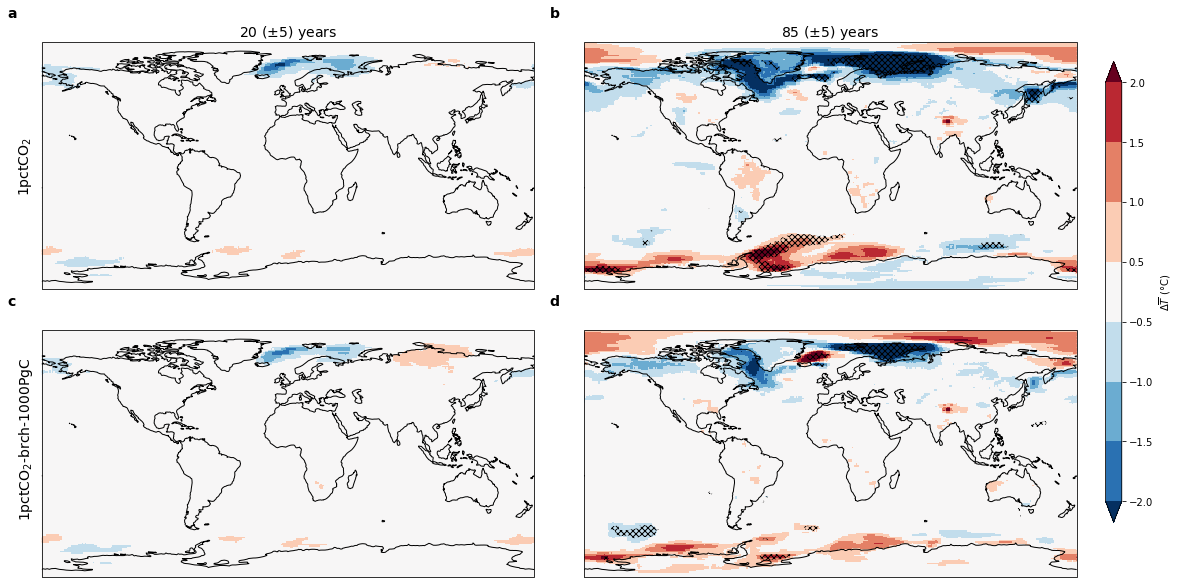

In [31]:
cmap = mpl.cm.RdBu_r
levels = [-2,-1.5,-1,-0.5,0.5,1,1.5,2.0]
vmin = -2
vmax = 2
yr_dif = 5
fig, ((ax1, ax2),(ax3, ax4))= plt.subplots(2, 2, figsize = [15,8], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

##########1pct exp##################
##contours of convolution-1pct difference
for t, ax in zip([20,85],[ax1,ax2]):
    if ax == ax1:
        add_cbar = False
    elif ax == ax2:
        add_cbar = True
    (ds_dif['tas']-conv_ds).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1pct').plot(ax = ax, 
                                                                                                                  cmap = cmap, levels = levels, extend = 'both', 
                                                                                                                  add_colorbar = False,     
                                                                                                                  transform = ccrs.PlateCarree())
    
    ax.set_title(f'{t} ($\pm 5$) years', fontsize = 14)
    ax.coastlines()
##hatching for locations where convolution falls within 1std
cs = hatching.sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1pct').plot.contourf(ax = ax2, hatches = ['xxxx', ''], levels = 3, colors = 'none', transform = ccrs.PlateCarree(), add_colorbar = False)
for i, collection in enumerate(cs.collections):
    collection.set_edgecolor('black')
for collection in cs.collections:
    collection.set_linewidth(0.)
ax2.set_title('85 ($\pm 5$) years', fontsize = 14)

############ 1000gtc exp##############
for t, ax in zip([20,85],[ax3,ax4]):
    if ax == ax3:
        add_cbar = False
    elif ax == ax4:
        add_cbar = True
    axp = (ds_dif['tas'] - conv_ds).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1000gtc').plot(ax = ax, 
                                                                                                                  cmap = cmap, levels = levels, extend = 'both', 
                                                                                                                  add_colorbar = False,     
                                                                                                                  transform = ccrs.PlateCarree())

    ax.coastlines()
    
##hatching for locations where convolution falls within 1std
cs = hatching.sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1000gtc').plot.contourf(ax = ax4, hatches = ['xxxx', ''], levels = 3, colors = 'none', transform = ccrs.PlateCarree(), add_colorbar = False)
for i, collection in enumerate(cs.collections):
    collection.set_edgecolor('black')
for collection in cs.collections:
    collection.set_linewidth(0.)
    


cbaxes = fig.add_axes([1.02,.1,.015,.8])
cb = plt.colorbar(axp, cax = cbaxes)
cb.set_label('$\Delta \overline{T}$ ($\degree$C)')

ax1.text(-0.05,.4,'1pctCO$_2$', rotation = 'vertical', fontsize = 14, transform=ax1.transAxes)
ax3.text(-0.05,.25,'1pctCO$_2$-brch-1000PgC', rotation = 'vertical', fontsize = 14, transform=ax3.transAxes)
ax3.set_title(None)
ax4.set_title(None)



#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4]:
    label = next(alpha_labels)
    ax.text(x = -0.07, y =1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

plt.savefig(f'figures/paper/figure2_20_85_difference_1std.png', bbox_inches = 'tight', dpi = 300)

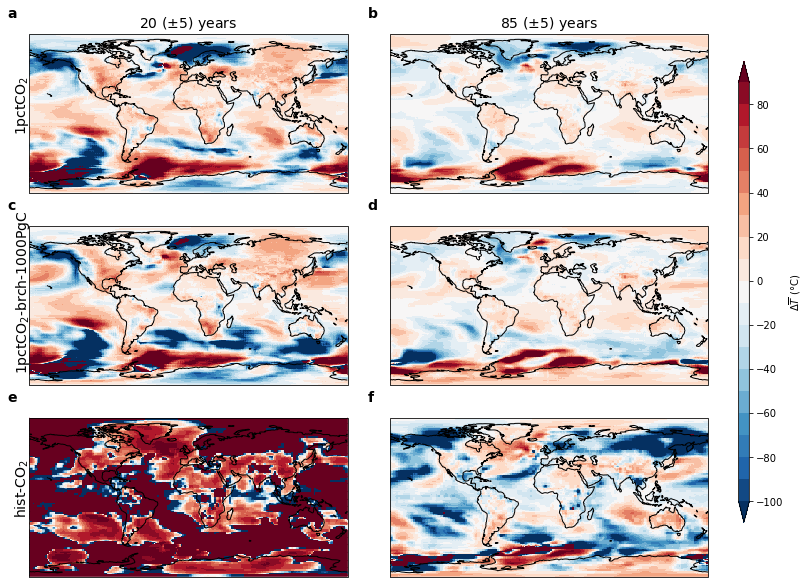

In [14]:
cmap = mpl.cm.RdBu_r
levels = np.arange(-100,100,10)#[-2,-1.5,-1,-0.5,0.5,1,1.5,2.0]
vmin = -2
vmax = 2
yr_dif = 5
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6))= plt.subplots(3, 2, figsize = [10,8], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

##########1pct exp##################
##contours of convolution-1pct difference
for t, ax in zip([20,85],[ax1,ax2]):
    if ax == ax1:
        add_cbar = False
    elif ax == ax2:
        add_cbar = True
    (((ds_dif['tas'] - conv_ds).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1pct')/
        ds_dif['tas'].weighted(model_weights).mean(dim = 'model').sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1pct')) * 100).plot(ax = ax, 
                                                                                                                  cmap = cmap, levels = levels, extend = 'both', 
                                                                                                                  add_colorbar = False,     
                                                                                                                  transform = ccrs.PlateCarree())
    
    ax.set_title(f'{t} ($\pm 5$) years', fontsize = 14)
    ax.coastlines()
##hatching for locations where convolution falls within 1std
# cs = hatching.sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1pct').plot.contourf(ax = ax2, hatches = ['xxxx', ''], levels = 3, colors = 'none', transform = ccrs.PlateCarree(), add_colorbar = False)
# for i, collection in enumerate(cs.collections):
#     collection.set_edgecolor('black')
# for collection in cs.collections:
#     collection.set_linewidth(0.)
# ax2.set_title('85 ($\pm 5$) years', fontsize = 14)

############ 1000gtc exp##############
for t, ax in zip([20,85],[ax3,ax4]):
    if ax == ax3:
        add_cbar = False
    elif ax == ax4:
        add_cbar = True
    ((((ds_dif['tas'] - conv_ds).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1000gtc'))/
                    ds_dif['tas'].weighted(model_weights).mean(dim = 'model').sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1000gtc')) * 100).plot(ax = ax, 
                                                                                                                  cmap = cmap, levels = levels, extend = 'both', 
                                                                                                                  add_colorbar = False,     
                                                                                                                  transform = ccrs.PlateCarree())

    ax.coastlines()
    
    ##hatching for locations where convolution falls within 1std
#     cs = hatching.sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1000gtc').plot.contourf(ax = ax4, hatches = ['xxxx', ''], levels = 3, colors = 'none', transform = ccrs.PlateCarree(), add_colorbar = False)
#     for i, collection in enumerate(cs.collections):
#         collection.set_edgecolor('black')
#     for collection in cs.collections:
#         collection.set_linewidth(0.)
    

############ hist-co2 exp##############
for t, ax in zip([20,85],[ax5,ax6]):
    if ax == ax5:
        add_cbar = False
    elif ax == ax6:
        add_cbar = True
    axp = ((((ds_hist_dif['tas'] - conv_hist_mod_mean_ds).mean(dim = ['pulse_type', 'model']).sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's'))/
                    ds_hist_dif['tas'].mean(dim = ['model']).sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's')) * 100).plot(ax = ax, 
                                                                                                                  cmap = cmap, levels = levels, extend = 'both', 
                                                                                                                  add_colorbar = False,     
                                                                                                                  transform = ccrs.PlateCarree())

    ax.coastlines()
    
    ##hatching for locations where convolution falls within 1std
#     cs = hatching_hist.sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').plot.contourf(ax = ax, hatches = ['xxxx', ''], levels = 3, colors = 'none', transform = ccrs.PlateCarree(), add_colorbar = False)
#     for i, collection in enumerate(cs.collections):
#         collection.set_edgecolor('black')
#     for collection in cs.collections:
#         collection.set_linewidth(0.)


cbaxes = fig.add_axes([1.02,.1,.015,.8])
cb = plt.colorbar(axp, cax = cbaxes)
cb.set_label('$\Delta \overline{T}$ ($\degree$C)')

ax1.text(-0.05,.4,'1pctCO$_2$', rotation = 'vertical', fontsize = 14, transform=ax1.transAxes)
ax3.text(-0.05,.1,'1pctCO$_2$-brch-1000PgC', rotation = 'vertical', fontsize = 14, transform=ax3.transAxes)
ax5.text(-0.05,.4,'hist-CO$_2$', rotation = 'vertical', fontsize = 14, transform=ax5.transAxes)

ax3.set_title(None)
ax4.set_title(None)
ax5.set_title(None)
ax6.set_title(None)



#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    label = next(alpha_labels)
    ax.text(x = -0.07, y =1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

plt.savefig(f'figures/paper/figure2_20_85_percent_difference_1std.png', bbox_inches = 'tight', dpi = 300)

## Temperature Change

/tmp/ipykernel_1441/3057282965.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.3)


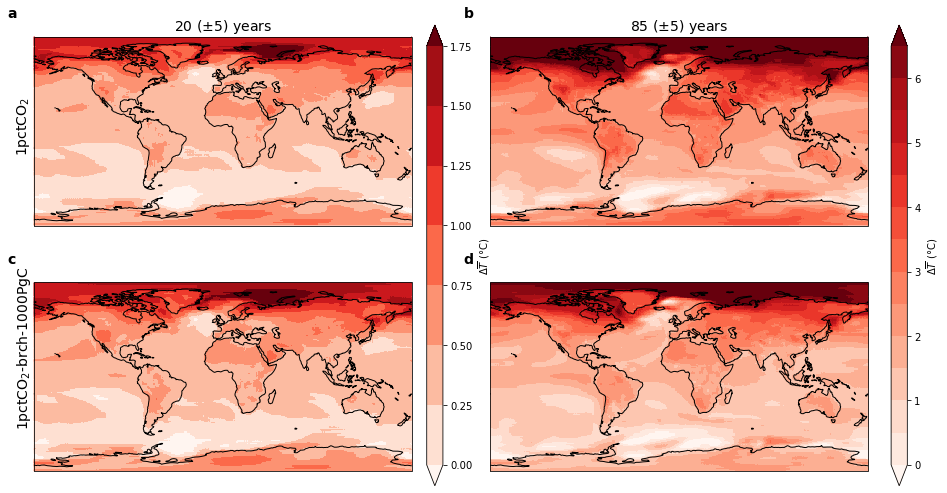

In [23]:
cmap = mpl.cm.Reds
levels = {20:np.arange(0,2,0.25) , 85:np.arange(0,7,0.5)}
vmin = -2
vmax = 2
yr_dif = 5
fig, ((ax1, ax2),(ax3, ax4))= plt.subplots(2, 2, figsize = [15,8], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)
plt.subplots_adjust(hspace=0.3)

##########1pct exp##################
##contours of convolution-1pct difference
for t, ax in zip([20,85],[ax1,ax2]):
    if ax == ax1:
        add_cbar = False
    elif ax == ax2:
        add_cbar = True
    axp1 = (conv_ds).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1pct').plot(ax = ax, 
                                                                                                                  cmap = cmap, levels = levels[t], extend = 'both', 
                                                                                                                  add_colorbar = False,     
                                                                                                                  transform = ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{t} ($\pm 5$) years', fontsize = 14)

    if t == 20:
        cbaxes = fig.add_axes([.49,.1,.015,.8])
        cb = plt.colorbar(axp1, cax = cbaxes)
        cb.set_label('$\Delta \overline{T}$ ($\degree$C)')


ax2.set_title('85 ($\pm 5$) years', fontsize = 14)


############ 1000gtc exp##############
for t, ax in zip([20,85],[ax3,ax4]):
    if ax == ax3:
        add_cbar = False
    elif ax == ax4:
        add_cbar = True
    axp = (conv_ds).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1000gtc').plot(ax = ax, 
                                                                                                                  cmap = cmap, levels = levels[t], extend = 'both', 
                                                                                                                  add_colorbar = False,     
                                                                                                                  transform = ccrs.PlateCarree())

    ax.coastlines()
    

cbaxes = fig.add_axes([0.92,.1,.015,.8])
cb = plt.colorbar(axp, cax = cbaxes)
cb.set_label('$\Delta \overline{T}$ ($\degree$C)')

ax1.text(-0.05,.4,'1pctCO$_2$', rotation = 'vertical', fontsize = 14, transform=ax1.transAxes)
ax3.text(-0.05,.25,'1pctCO$_2$-brch-1000PgC', rotation = 'vertical', fontsize = 14, transform=ax3.transAxes)
ax3.set_title(None)
ax4.set_title(None)

#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4]:
    label = next(alpha_labels)
    ax.text(x = -0.07, y =1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

plt.savefig(f'figures/paper/supp_figure2_20_85.png', bbox_inches = 'tight', dpi = 300)